In [922]:
from pymongo import MongoClient
from elasticsearch import Elasticsearch, helpers
import requests
from IPython.display import JSON
import numpy as np
from fuzzywuzzy import fuzz
from joblib import Parallel, delayed
import pickle
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
import math
from thefuzz import fuzz, process
import re
from IPython.display import clear_output, display
import json
from unidecode import unidecode
from colavsim import colav_similarity, parse_doi, parse_string
import sys

In [3]:
es = Elasticsearch(timeout=120)

In [4]:
# open a file, where you stored the pickled data
file = open('dataset_full.pkl', 'rb')
# dump information to that file
data = pickle.load(file)
# close the file
file.close()

In [5]:
len(data["p"])

101773

In [6]:
len(data["n"])

41596

In [7]:
data["p"][0]

{'Authors': 'Jaramillo-Ayerbe F., Berrío-Muñoz J.',
 'Title': 'Ivermectin for crusted Norwegian scabies induced by use of topical steroids',
 'Year': 1998,
 'Source title': 'Archives of Dermatology',
 'Volume': '134',
 'Issue': '2',
 'Page start': '143',
 'Page end': '145',
 'DOI': '10.1001/archderm.134.2.143'}

In [8]:
data["n"][0]

{'Authors': 'Flórez G.A.D., Mombello E.E., Voss S.',
 'Title': 'Novel technique for the calculation of eddy current losses and Lorentz forces in foil winding transformers',
 'Year': 2017,
 'Source title': 'International Journal of Applied Electromagnetics and Mechanics',
 'Volume': '55',
 'Issue': '1',
 'Page start': '75',
 'Page end': '88',
 'DOI': '10..3233/JAE-160144'}

In [9]:
scopus = []
#np.random.shuffle(data["p"])
#np.random.shuffle(data["n"])
for i in data["p"][0:3001]:
    scopus.append((i,True))
for i in data["n"][0:3000]:
    scopus.append((i,False))

In [906]:
es_index = list(es.indices.get_alias("*").keys())
print(es_index)
es_index.remove("openalex_raw")
es_index.remove("openalex_dfr")
es_index = "openalex_raw"

['openalex_dfr', 'openalex_parsed', 'openalex_raw', 'openalex_lmdirichlet']


/tmp/ipykernel_43864/378770228.py:1: DeprecationWarning: Using positional arguments for APIs is deprecated and will be disabled in 8.0.0. Instead use only keyword arguments for all APIs. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  es_index = list(es.indices.get_alias("*").keys())


In [907]:
def get_oa_doi(es_reg):
    for i in es_reg["_source"]['external_ids']:
        if i['source'] == "doi":
            return i["id"]


def get_oa_doi(es_reg):
    return es_reg["_source"]['doi']


In [908]:
def search(Title, Authors, Source, Year, Volume, Issue, PageStart, PageEnd, punto_de_corte = 0):
    """
    Definir el valor mínimo del _score que deseas
    Puedes ajustar este valor según tus necesidades

    """
    if not isinstance(Title, str):
        Title = ""
    if not isinstance(Source, str):
        Source = ""
    if not isinstance(Volume, str) or not isinstance(Volume, int):
        Volume = ""
    if not isinstance(Issue, str) or not isinstance(Issue, int):
        Issue = ""
    if not isinstance(PageStart, str) or not isinstance(PageStart, int):
        PageStart = ""
    if not isinstance(PageEnd, str) or not isinstance(PageEnd, int):
        PageEnd = ""

    body = {
        "query": {
            "bool": {
                "should": [
                    { "match": { "title": Title}},
                    # { "match_phrase": { "title": { "query": Title, "boost": 2 }}},
                    #{ "match": { "title": { "query": Title, "boost": 4 }}},
                    { "match": { "authorships.author.display_name":  Authors[0:100] }},# se tienen que truncar los autores 
                    { "match": { "host_venue.display_name":  Source}},
                    { "term": { "publication_year": Year }},
                    { "term": { "biblio.volume": Volume }},
                    { "term": { "biblio.issue": Issue }},
                    { "term": { "biblio.first_page": PageStart }},
                    { "term": { "biblio.last_page": PageEnd }},
                    
                ] ,
            }
        },
        "size": 10,
        "min_score": punto_de_corte
    }
    
    res = es.search(index=es_index, **body)
    return  res

In [909]:
def parse_string(string:str):
    data = str(string).lower()
    data = re.sub(r'<[^>]+>','',data)
    data = unidecode(data)
    return data    
def parse_doi(doi):
    
    return re.sub(r'https*\:\/\/[\w\.]+\/','',str(doi).lower())

In [925]:
%%time
#ratio_thold=90, partial_thold=90,low_thold=85) #3000 / fn = 26
#ratio_thold=95, partial_thold=90,low_thold=80 #3000 / fn = 25
#ratio_thold=90, partial_thold=90,low_thold=80 #3000 / fn = 24
#dfr fn = 47 Title, Source year 
#openalex_parsed fn =37  all fields
#openalex_parsed fn = .79  all fields all dataset
#openalex_parsed fn = 0.70 fp 6.041  all fields all dataset mode 3


def es_similarity(rec,th_high = 0, th_low = 0, mode = 0):
    res = search(parse_string(rec['Title']),rec['Authors'],rec['Source title'],rec['Year'],
                 rec['Volume'], rec['Issue'], rec['Page start'], rec['Page end'],0)
    if res["hits"]["total"]["value"] != 0:
        _score = res["hits"]["hits"][0]["_score"]
        if mode == 0: # tests mode (perfect case)
            oa_doi = get_oa_doi(res["hits"]["hits"][0]).lower()
            sc_doi = rec["DOI"].lower()
            if parse_doi(oa_doi) == parse_doi(sc_doi):
                return (True,res["hits"]["hits"][0]["_score"])
            else:
                return (False,res["hits"]["hits"][0]["_score"])           
        if mode == 1: # la salida la evalua colav similarity, solo sobre el mejor hit
            i = res["hits"]["hits"][0]
            value = colav_similarity(rec['Title']       ,  i["_source"]['title'],
                                    rec['Source title'],   i["_source"]["host_venue"]["display_name"],
                                    rec['Year']        ,   i["_source"]['publication_year'],
                                    ratio_thold=90, partial_thold=95,low_thold=80)
            return (value,i["_score"])
        if mode == 2: # después de los cortes la salida la evalua colav similarity
            if _score >= th_high:
                return (True,_score)
            elif _score <= th_low:
                return (False,_score)
            else:
                i = res["hits"]["hits"][0]
                value = colav_similarity(rec['Title']       ,  i["_source"]['title'],
                                        rec['Source title'],   i["_source"]["host_venue"]["display_name"],
                                        rec['Year']        ,   i["_source"]['publication_year'],
                                        ratio_thold=90, partial_thold=95,low_thold=80)
                return (value,i["_score"])
        if mode == 3: # la salida la evalua colav similarity sobre los 10 primeros hits
            for i in res["hits"]["hits"]:
                value = colav_similarity(rec['Title']       ,  i["_source"]['title'],
                                        rec['Source title'],   i["_source"]["host_venue"]["display_name"],
                                        rec['Year']        ,   i["_source"]['publication_year'],
                                        ratio_thold=90, partial_thold=95,low_thold=80)
                if value:
                    return (True, i["_score"])
                
            return (False,_score)
        
        print("ERROR: method no valid, select 0,1,2 or 3")
        sys.exit(1)
    else:
        return (False,0)
scopus = []
np.random.shuffle(data["p"])
np.random.shuffle(data["n"])
for i in data["p"]:#[0:5001]:
    scopus.append((i,True))
for i in data["n"]:#[0:5000]:
    scopus.append((i,False))
np.random.shuffle(scopus) #shuffle is inplace
th_high=140
th_low =5
mode = 3
results = Parallel(n_jobs=64,backend='threading',verbose=2)(delayed(es_similarity)(rec[0],th_high, th_low, mode) for rec in scopus)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done 237 tasks      | elapsed:    2.7s
[Parallel(n_jobs=64)]: Done 520 tasks      | elapsed:    5.2s
[Parallel(n_jobs=64)]: Done 885 tasks      | elapsed:    7.6s
[Parallel(n_jobs=64)]: Done 1330 tasks      | elapsed:   11.5s
[Parallel(n_jobs=64)]: Done 1857 tasks      | elapsed:   16.0s
[Parallel(n_jobs=64)]: Done 2464 tasks      | elapsed:   20.7s
[Parallel(n_jobs=64)]: Done 3153 tasks      | elapsed:   27.5s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   33.9s
[Parallel(n_jobs=64)]: Done 4773 tasks      | elapsed:   41.2s
[Parallel(n_jobs=64)]: Done 5704 tasks      | elapsed:   49.0s
[Parallel(n_jobs=64)]: Done 6717 tasks      | elapsed:   57.7s
[Parallel(n_jobs=64)]: Done 7810 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 8985 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 10240 tasks 

CPU times: user 21min 1s, sys: 2min 13s, total: 23min 15s
Wall time: 20min 55s


[Parallel(n_jobs=64)]: Done 143369 out of 143369 | elapsed: 20.9min finished


In [926]:
#>tp, tn, fp, fn
actual = []
predicted = []
for i in range(len(results)):
    if results[i] is not None:
        actual.append(scopus[i][1])
        predicted.append(results[i][0])


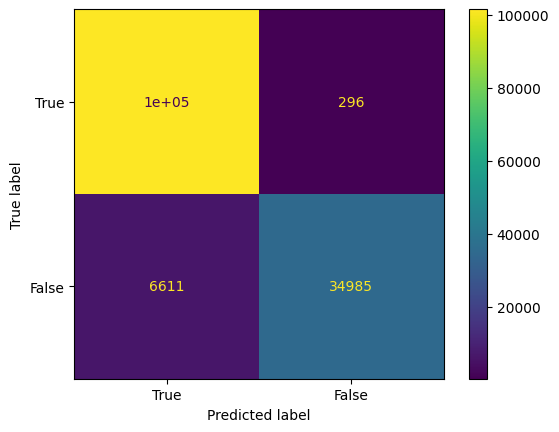

In [927]:
confusion_matrix = metrics.confusion_matrix(actual, predicted)
confusion_matrix = np.flip(confusion_matrix)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [True, False])

cm_display.plot()
plt.show()

In [928]:
fn = confusion_matrix[0][1]*100/(confusion_matrix[0][0]+confusion_matrix[0][1])
fn

0.2908433474497165

In [929]:
fp = confusion_matrix[1][0]*100/len(data["n"])
fp

15.893355130300991

In [930]:
acc = metrics.accuracy_score(actual,predicted)
pre = metrics.precision_score(actual,predicted)
rec = metrics.recall_score(actual,predicted)
f1  = metrics.f1_score(actual,predicted)

print(f"Accuracy  = {acc:.4f}")
print(f"Precision = {pre:.4f}")
print(f"Recall    = {rec:.4f}")
print(f"F1        = {f1:.4f}")


Accuracy  = 0.9518
Precision = 0.9388
Recall    = 0.9971
F1        = 0.9671


In [931]:
score_p = []
score_n = []
for i in results:
    if i[0]:
        score_p.append(i[1])
    else:
        score_n.append(i[1])  

In [932]:
np.mean(score_p)

133.43481569667307

In [933]:
len(score_p)

108088

In [934]:
len(score_n)

35281

In [935]:
f_score_p = []
f_score_n = []

for i in score_p:
    if i<1000:
        f_score_p.append(i)

for i in score_n:
    if i<1000:
        f_score_n.append(i)

In [936]:
f_score_p = np.array(f_score_p)
f_score_n = np.array(f_score_n)


In [937]:
f_score_p.max()


433.86816

In [938]:
# Obtiene la información del histograma
valores_p, bordes_p = np.histogram(f_score_p, bins=100, density=True)
centros_p = 0.5 * (bordes_p[:-1] + bordes_p[1:])

# Encuentra el valor máximo en el eje Y
valor_maximo_y_p = max(valores_p)

# Encuentra el valor en el eje X para el cual Y es máximo
valor_maximo_x_p = centros_p[np.argmax(valores_p)]
valor_maximo_x_p

137.51684441999998

In [939]:
# Obtiene la información del histograma
valores_n, bordes_n = np.histogram(f_score_n, bins=100, density=True)
centros_n = 0.5 * (bordes_n[:-1] + bordes_n[1:])

# Encuentra el valor máximo en el eje Y
valor_maximo_y_n = max(valores_n)

# Encuentra el valor en el eje X para el cual Y es máximo
valor_maximo_x_n = centros_p[np.argmax(valores_n)]
valor_maximo_x_n

53.445549220000004

True

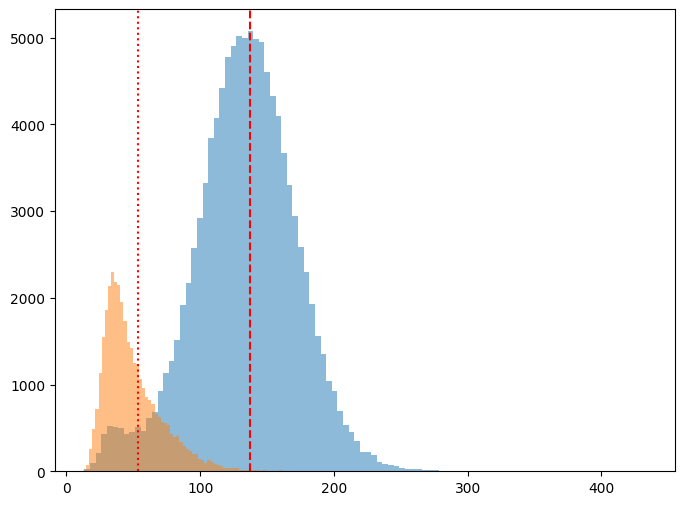

In [905]:
n_bins = 100


plt.figure(figsize=(8,6))
plt.hist(f_score_p, bins=100, alpha=0.5, label="data1", density=False)
plt.hist(f_score_n, bins=100, alpha=0.5, label="data1", density=False)
# Dibuja una línea vertical en el punto máximo
plt.axvline(x=valor_maximo_x_p, color='r', linestyle='--', label=f'Máximo en X: {valor_maximo_x_p:.2f}')
plt.axvline(x=valor_maximo_x_n, color='r', linestyle=':', label=f'Máximo en X: {valor_maximo_x_n:.2f}')

True